# Comparison to BorutaShap



In [15]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml
from sklearn.inspection import permutation_importance
import catboost
from catboost import CatBoostRegressor, CatBoostClassifier
from boruta import BorutaPy as bp
from sklearn.datasets import load_boston, load_diabetes, load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import shap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sys import getsizeof, path
import arfs
import arfs.featselect as arfsfs
import arfs.allrelevant as arfsgroot
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.utils import highlight_tick, compare_varimp
from arfs.utils import load_data, sklearn_pimp_bench
from boruta import BorutaPy
plt.style.use('fivethirtyeight')
rng = np.random.RandomState(seed=42)

import warnings
warnings.filterwarnings('ignore')

In [16]:
%matplotlib inline

In [17]:
gc.enable()
gc.collect()

36901

## Comparison

I'll just remove the collinear predictors since they are actually harmful for the ARFS, see the [Collinearity notebook](./Collinearity.ipynb)

In [18]:
cancer = load_data(name='cancer')
X, y = cancer.data, cancer.target
# New instance of the class
fs = arfsfs.FeatureSelector(X = X, y = y, sample_weight = None)
# identify highly correlated columns (here corr_coef >= 0.75)
# set encode to True if there are categorical/string cols (takes a bit of time)
fs.identify_collinear(correlation_threshold=0.75, encode=False)
# tag the discarded predictors and store the results
fs_df = fs.tag_df
fs.ops['collinear']
# Plot and save the corr-map
heatmap = fs.plot_collinear(plot_all=True, size=800)
heatmap
# hv.save(heatmap, "C:User/my_folder/heatmap_corr.html")

Corr matrix done,    0 min and    0 min from start
20 features with a correlation magnitude greater than 0.75.



Column(background='#ebebeb')
    [0] Markdown(str)
    [1] Markdown(str)
    [2] HoloViews(HeatMap)

In [19]:
X_filtered = fs.remove(methods=['collinear'])
X_filtered.head()

,mean smoothness,mean symmetry,texture error,perimeter error,smoothness error,concavity error,symmetry error,worst texture,worst concave points,worst symmetry,random_num1,random_num2,genuine_num
0,0.11840,0.2419,0.9053,8.589,0.006399,0.05373,0.03003,17.33,0.2654,0.4601,0.496714,0,0.069345
1,0.08474,0.1812,0.7339,3.398,0.005225,0.01860,0.01389,23.41,0.1860,0.2750,-0.138264,1,0.110353
2,0.10960,0.2069,0.7869,4.585,0.006150,0.03832,0.02250,25.53,0.2430,0.3613,0.647689,0,-0.043507
3,0.14250,0.2597,1.1560,3.445,0.009110,0.05661,0.05963,26.50,0.2575,0.6638,1.523030,1,-0.009029
4,0.10030,0.1809,0.7813,5.438,0.011490,0.05688,0.01756,16.67,0.1625,0.2364,-0.234153,0,-0.042229


### BorutaShap

BorutaShap, is an alternative implementation (heavy re-writting and new material) of Boruta with Shap feature importance. Let's see what are the results on this data set

  0%|          | 0/100 [00:00<?, ?it/s]

11 attributes confirmed important: ['symmetry error', 'texture error', 'worst concave points', 'genuine_num', 'perimeter error', 'mean symmetry', 'mean smoothness', 'smoothness error', 'worst texture', 'concavity error', 'worst symmetry']
2 attributes confirmed unimportant: ['random_num1', 'random_num2']
0 tentative attributes remains: []


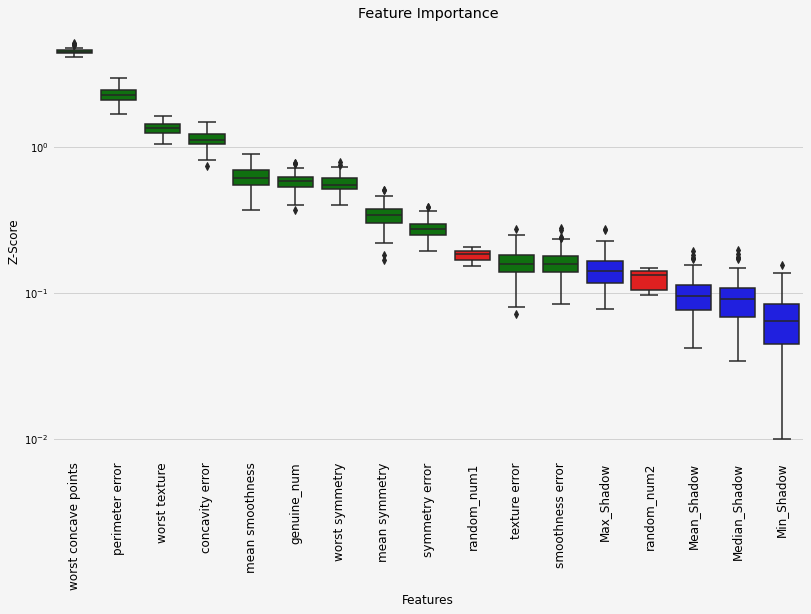

Wall time: 32.3 s


In [27]:
%%time

from BorutaShap import BorutaShap
from arfs.utils import cat_var

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define BorutaShap feature selection method (doesn't convert automatically cat feature)
# X_encoded, cat_var_df, inv_mapper = cat_var(X_filtered)
bs_feat_selector = BorutaShap(model=rf, importance_measure='shap', classification=True)

# find all relevant features - 5 features should be selected
bs_feat_selector.fit(X=X_filtered, y=y, n_trials=100, random_state=0)

# Returns Boxplot of features
bs_feat_selector.plot(X_size=12, figsize=(12,8), y_scale='log', which_features='all')

In [21]:
bs_feat_selector.accepted

['symmetry error',
 'texture error',
 'worst concave points',
 'genuine_num',
 'perimeter error',
 'mean symmetry',
 'mean smoothness',
 'smoothness error',
 'worst texture',
 'concavity error',
 'worst symmetry']

### Leshy

Let's compare to the official python implementation, using the same setting and the gini/gain feature importance. We should have the same results (btw, you can check the unit tests, BorutaPy is used as baseline).

Leshy iteration:   8%|██████▍                                                                         | 8/100 [00:01<00:20,  4.47it/s]




Leshy finished running using shap var. imp.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	2
All relevant predictors selected in 00:00:01.80


['mean smoothness', 'mean symmetry', 'texture error', 'perimeter error', 'smoothness error', 'concavity error', 'symmetry error', 'worst texture', 'worst concave points', 'worst symmetry', 'genuine_num']


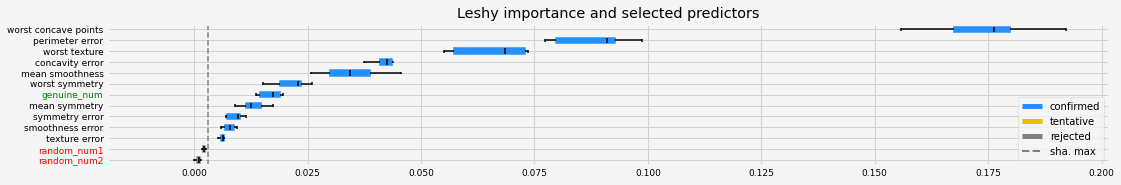

Wall time: 2.09 s


In [22]:
%%time
# Leshy, all the predictors, no-preprocessing
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
leshy_feat_selector = arfsgroot.Leshy(rf, n_estimators = 'auto', verbose= 1, max_iter= 100, random_state=1, importance='shap')
leshy_feat_selector.fit(X_filtered, y)
print("\n")
print(leshy_feat_selector.support_names_)
fig = leshy_feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match='random')
fig = highlight_tick(figure=fig, str_match='genuine', color='green')
plt.show()

In [23]:
print(f"The agnostic ranking {leshy_feat_selector.ranking_}")
print(f"The naive ranking {leshy_feat_selector.ranking_absolutes_}")

The agnostic ranking [1 1 1 1 1 1 1 1 1 1 2 3 1]
The naive ranking ['worst concave points', 'perimeter error', 'worst texture', 'concavity error', 'mean smoothness', 'worst symmetry', 'genuine_num', 'mean symmetry', 'symmetry error', 'smoothness error', 'texture error', 'random_num1', 'random_num2']


### Same Results?

In [24]:
def check_list_equal(L1, L2):
    return len(L1) == len(L2) and sorted(L1) == sorted(L2)

In [25]:
check_list_equal(leshy_feat_selector.support_names_, list(bs_feat_selector.accepted))

True

## Timing

Note that the original BorutaPy, on which Leshy is based, runs significantly faster due to an early stopping process.